In [2]:
!nvidia-smi

Fri Jan  3 14:12:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
#!pip install sentencepiece

     |████████████████████████████████| 1.0MB 12.3MB/s 


In [4]:
import sys
from google.colab import drive
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/deeplearning/Sentence_VAE/'
sys.path.append(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


# Imports

In [0]:
# import model
#from modules.model import RNN_VAE, word_dropout

# import loss functions
from modules.loss_functions import ELBO_loss, ELBO_lAnneal, ELBO_cAnneal, ELBO_cAnnealFB, cycAnneal

# import utils
from modules.utils import print_generative_reconstruction, print_reconstruction, plot_loss, get_latent_representation, getActiveUnits

In [0]:
import torch
from torch.utils.data import DataLoader
from torch import optim
import sentencepiece as spm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from IPython.display import Image, display, clear_output
import time

In [0]:
# Overwrite model for debug
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions import Categorical


def word_dropout(x, p):
    """
    Drops words in sentence, x, with probability p
    :param x: array with tokenized sentence
    :param p: float
    :return:
    """
    mask_prop = torch.rand_like(x, dtype=torch.float)
    mask = mask_prop < p
    x[mask] = 1 #Set to 'UNK'
    return x


class RNN_VAE(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, latent_dim, vocab_size, seq_length, word_dropout_p):
        """
        Initialize model
        :param embedding_dim: int
        :param hidden_dim: int
        :param latent_dim: int
        :param vocab_size: int
        :param seq_length: int
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.seq_length = seq_length
        self.word_dropout_p = word_dropout_p

        self.word_embeddings = nn.Embedding(vocab_size,
                                            embedding_dim)

        self.encoder_lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_sigma = nn.Linear(hidden_dim, latent_dim)

        self.linear_z_to_h0 = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(embedding_dim + latent_dim, hidden_dim, batch_first=True)
        self.decoder_linear = nn.Linear(hidden_dim, vocab_size)

    def encode(self, sentence):
        """
        Encodes the sentence into latent space (note no reparameterization trick here)
        :param sentence: tokenized sentence or batch of tokenized sentences [batch_size, seq_length]
        :return: tensors of batch size containing mu and sigma
        """
        embeds = self.word_embeddings(sentence[:, 1:])
        _, (hidden_state, gate_state) = self.encoder_lstm(embeds)
        mu = self.linear_mu(hidden_state)
        sigma = self.linear_sigma(hidden_state)
        return mu, sigma

    def reparameterize(self, mu, logvar):
        """
        The reparamerization trick
        :param mu: tensor of size batch_size with mu
        :param logvar: tensor of size batch_size with sigma
        :return: tensor of size batch_size with a sample from N(mu, sigma)
        """
        sigma = torch.exp(logvar / 2)
        eps = torch.randn_like(sigma)
        return mu + eps * sigma

    def decode(self, z, sentence):
        """
        Decodes a sentence given the latent space var
        :param z: sample from latent space of size batch_size
        :param sentence: tokenized sentence or batch of tokenized sentences [batch_size, seq_length]
        :return: tensor with logits of size [batch_size, seq_length - 1, vocab_size]
        """
        h_0 = self.linear_z_to_h0(z)
        masked_sentence = word_dropout(sentence[:, :-1].clone().detach(), self.word_dropout_p)
        embeds = self.word_embeddings(masked_sentence)
        embed_z = z.permute(1, 0, 2).expand(-1, self.seq_length - 1, -1)
        embeds_with_z = torch.cat((embeds, embed_z), 2)
        lstm_out, _ = self.decoder_lstm(embeds_with_z, (h_0, torch.zeros_like(h_0)))
        output = self.decoder_linear(lstm_out)
        return output

    def forward(self, sentence):
        """
        Runs the encode, reparameterize and decode in one call
        :param sentence: tokenized sentence or batch of tokenized sentences [batch_size, seq_length]
        :return: tensor with logits of size [batch_size, seq_length - 1, vocab_size] and tensors of size batch_size with
        mu and sigma
        """
        mu, logvar = self.encode(sentence)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, sentence)
        return output, mu, logvar

    def generative_reconstruction(self, sentence):
        """
        Takes in a tokenized sentence, encodes it and iteratively tries to reconstruct it 1 word at a time
        :param sentence: tokenized sentence or batch of tokenized sentences [batch_size, seq_length]
        :return: tensor with the reconstructed tokenized sentence
        """
        mu, logvar = self.encode(sentence)
        #z = self.reparameterize(mu, logvar)
        h_0 = self.linear_z_to_h0(mu)
        permuted_z = mu.permute(1, 0, 2)

        gen_recon_sentence = torch.cuda.LongTensor([[2]], device=next(iter(self.parameters())).device)
        for i in range(sentence.shape[1]):
            gen_embeds = self.word_embeddings(gen_recon_sentence)
            embed_z = permuted_z.expand(-1, i + 1, -1)
            gen_embeds_with_z = torch.cat((gen_embeds, embed_z), 2)
            _, (h_t, c_t) = self.decoder_lstm(gen_embeds_with_z, (h_0, torch.zeros_like(h_0)))
            gen_out = F.softmax(self.decoder_linear(h_t), dim=2)
            cat_dist = Categorical(gen_out)
            next_word = cat_dist.sample()
            next_word = torch.cuda.LongTensor([[next_word]], device=next(iter(self.parameters())).device)
            gen_recon_sentence = torch.cat((gen_recon_sentence, next_word), dim=1)
        return gen_recon_sentence

    def generate_sentence_from_latent(self, mu, sentence_len):
      h_0 = self.linear_z_to_h0(mu)
      permuted_z = mu.permute(1, 0, 2)

      gen_recon_sentence = torch.cuda.LongTensor([[2]], device=next(iter(self.parameters())).device)
      logits = []
      for i in range(sentence_len):
          gen_embeds = self.word_embeddings(gen_recon_sentence)
          embed_z = permuted_z.expand(-1, i + 1, -1)
          gen_embeds_with_z = torch.cat((gen_embeds, embed_z), 2)
          _, (h_t, c_t) = self.decoder_lstm(gen_embeds_with_z, (h_0, torch.zeros_like(h_0)))
          gen_out = F.softmax(self.decoder_linear(h_t), dim=2)
          cat_dist = Categorical(gen_out)
          next_word = cat_dist.sample()
          next_word = torch.cuda.LongTensor([[next_word]], device=next(iter(self.parameters())).device)
          gen_recon_sentence = torch.cat((gen_recon_sentence, next_word), dim=1)
      return gen_recon_sentence
    
    def deterministic_generate_sentence_from_latent(self, mu, sentence_len):
      h_0 = self.linear_z_to_h0(mu)
      permuted_z = mu.permute(1, 0, 2)

      gen_recon_sentence = torch.cuda.LongTensor([[2]], device=next(iter(self.parameters())).device)
      logits = []
      for i in range(sentence_len):
          gen_embeds = self.word_embeddings(gen_recon_sentence)
          embed_z = permuted_z.expand(-1, i + 1, -1)
          gen_embeds_with_z = torch.cat((gen_embeds, embed_z), 2)
          _, (h_t, c_t) = self.decoder_lstm(gen_embeds_with_z, (h_0, torch.zeros_like(h_0)))
          gen_out = F.softmax(self.decoder_linear(h_t), dim=2)
          _, index = gen_out.max(-1)
          next_word = index.squeeze().tolist()
          next_word = torch.cuda.LongTensor([[next_word]], device=next(iter(self.parameters())).device)
          gen_recon_sentence = torch.cat((gen_recon_sentence, next_word), dim=1)
      return gen_recon_sentence


In [0]:
def print_generative_reconstruction(rnn_vae, sp, sentence_in_batch, train_data_loader):
    """
    Takes a rnn_vae model and loads the first batch. Then tries to reconstruct the sentence at index sentence_in_batch
     using the generative_reconstruction method in rnn_vae
    :param rnn_vae: RNN_VAE object
    :param sp: SentencePieceProcessor object
    :param sentence_in_batch: int
    :param train_data_loader: pytorch DataLoader object
    :return:
    """
    rnn_vae.eval()
    test_batch = next(iter(train_data_loader))
    test_sentence = test_batch[sentence_in_batch]
    test_sentence_string = sp.decode_ids(test_sentence.tolist())
    output = rnn_vae.generative_reconstruction(test_sentence.view(1, -1).cuda())
    recon_sentence = sp.decode_ids(output.reshape(-1).tolist())
    print(f"Real sentence: {test_sentence_string}")
    print(f"Generated sentence: {recon_sentence}\n")

In [0]:
def pad_token_array(array, padded_len):
    len_array = len(array)
    padding = (padded_len - len_array) * [0]
    bos = [2]
    eos = [3]
    return torch.LongTensor(bos + array + padding + eos)

In [0]:
def get_latent_rep_of_sentence(rnn_vae, sp, sentence):
  rnn_vae.eval()

  if isinstance(sentence, str):
    token_arr = sp.encode_as_ids(sentence)
    padded_token_arr = pad_token_array(token_arr, SEQ_LEN-2)
    sentence = padded_token_arr

  mu, _ = rnn_vae.encode(sentence.unsqueeze(0).cuda())
  return mu
  

In [0]:
def deterministic_generate_sentence_from_latent(rnn_vae, sp, z, sentence_len):
  rnn_vae.eval()
  output = rnn_vae.deterministic_generate_sentence_from_latent(z, sentence_len)
  recon_sentence = sp.decode_ids(output.reshape(-1).tolist())
  return recon_sentence

def generate_sentence_from_latent(rnn_vae, sp, z, sentence_len):
  rnn_vae.eval()
  output = rnn_vae.generate_sentence_from_latent(z, sentence_len)
  recon_sentence = sp.decode_ids(output.reshape(-1).tolist())
  return recon_sentence



# Load data and model

Small

In [15]:
data_dict = pickle.load( open( root_path + "FR_data_set_sub10.p", "rb" ))
training_data = data_dict["train"]["formal"] + data_dict["train"]["informal"]
test_data = data_dict["test"]["formal"] + data_dict["test"]["informal"]
print("FR part")
print(f"train formal len: {len(data_dict['train']['formal'])}")
print(f"train informal len: {len(data_dict['train']['informal'])}")
print(f"test formal len: {len(data_dict['test']['formal'])}")
print(f"test informal len: {len(data_dict['test']['informal'])}")
print("\nData sizes")
print(f"training data len: {len(training_data)}")
print(f"test data len: {len(test_data)}")

FR part
train formal len: 12824
train informal len: 12824
test formal len: 582
test informal len: 582

Data sizes
training data len: 25648
test data len: 1164


Large

In [0]:
# Load sentencepiece model (See local notebook for how to create the sentencepiece model)

#small
sp = spm.SentencePieceProcessor()
sp.Load(root_path + 'FRtraintest16000.model')
VOCAB_SIZE = 16000

#large
#sp = spm.SentencePieceProcessor()
#sp.Load(root_path + 'fulltraintest32000.model')
#VOCAB_SIZE = 32000

Small

In [0]:
BATCH_SIZE = 2048
from torch.utils.data import DataLoader

train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE)



In [21]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
LATENT_DIM = 64
SEQ_LEN = 12 #padded + EOS + SOS
WORD_DROPOUT_P = 0.25
rnn_vae =  RNN_VAE(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM,
                  latent_dim=LATENT_DIM, vocab_size=VOCAB_SIZE, seq_length=SEQ_LEN, word_dropout_p=WORD_DROPOUT_P).cuda()

rnn_vae.load_state_dict(torch.load(root_path + "trained_models/" + "FB_CA_WD_RNN_VAE_small.pt"))

<All keys matched successfully>

## Results

#### Qualitative results

In [22]:
print_generative_reconstruction(rnn_vae=rnn_vae, sp=sp, sentence_in_batch=0, train_data_loader=train_data_loader)

Real sentence: the person yr looking for is not me.
Generated sentence: the man gets both a guy-assurance.



In [23]:
for i in range(10):
  print_generative_reconstruction(rnn_vae=rnn_vae, sp=sp, sentence_in_batch=i, train_data_loader=train_data_loader)
  print('*******')

Real sentence: i do belive its easy in mexico good luck.
Generated sentence: i believe i can't have any more.

*******
Real sentence: dont worry and go for it if so.
Generated sentence: then you go out and give it a try.

*******
Real sentence: the key is to show that you are different!
Generated sentence: the only thing was no amount of searching is.

*******
Real sentence: ask if you could join in.
Generated sentence: see how things go by guys before

*******
Real sentence: just wondering and support ur answers?
Generated sentence: just tell him that you feel.

*******
Real sentence: just be yourself: don't be fake!!!!!!!!
Generated sentence: just get left too close and one out once!

*******
Real sentence: don't waste your virginity nor any time.
Generated sentence: don't hesitate, ask yourself first you.

*******
Real sentence: i am very angry with my best friend.
Generated sentence: i am blind in, so happy we.

*******
Real sentence: what man wouldn't love to hear that?
Generated 

# Latent space exploration

In [0]:
# embed all the stuff into the latent space
def get_latent_representation(token_sentences, rnn_vae):
  rnn_vae.eval()
  embeds = []
  for sentence in token_sentences:
    mu, sigma = rnn_vae.encode(sentence.unsqueeze(0).cuda())
    z = rnn_vae.reparameterize(mu, sigma)
    embeds.append(z.detach().squeeze().cpu().tolist())
  rnn_vae.train()
  return embeds

In [0]:
FR_formal_embeds = get_latent_representation(data_dict["train"]["formal"], rnn_vae)
FR_informal_embeds = get_latent_representation(data_dict["train"]["formal"], rnn_vae)

In [0]:
from sklearn.manifold import TSNE
import seaborn as sns

In [0]:
# EM, FR, formal, informal order
plot_subset = FR_formal_embeds[0:2000] + FR_informal_embeds[0:2000]

In [32]:
tsne = TSNE(n_components=2, verbose=1, init='pca', perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(plot_subset)
tsne_df = pd.DataFrame(tsne_results, columns=["x","y"])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.015s...
[t-SNE] Computed neighbors for 4000 samples in 2.316s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 2.082107
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.393623
[t-SNE] KL divergence after 1000 iterations: 2.942676


In [0]:
groups = [x // 2000 for x in range(len(plot_subset))]
tsne_df["group"] = groups
formality_dict = {0: "formal", 1: "informal"}

In [0]:
tsne_df['formality'] = tsne_df.apply (lambda row: formality_dict[row.group], axis=1)

In [0]:
group0 = tsne_df.loc[tsne_df.group == 0][0:200]
group1 = tsne_df.loc[tsne_df.group == 1][0:200]

In [0]:
frames = [group0, group1]
sub_tsne_df = pd.concat(frames)

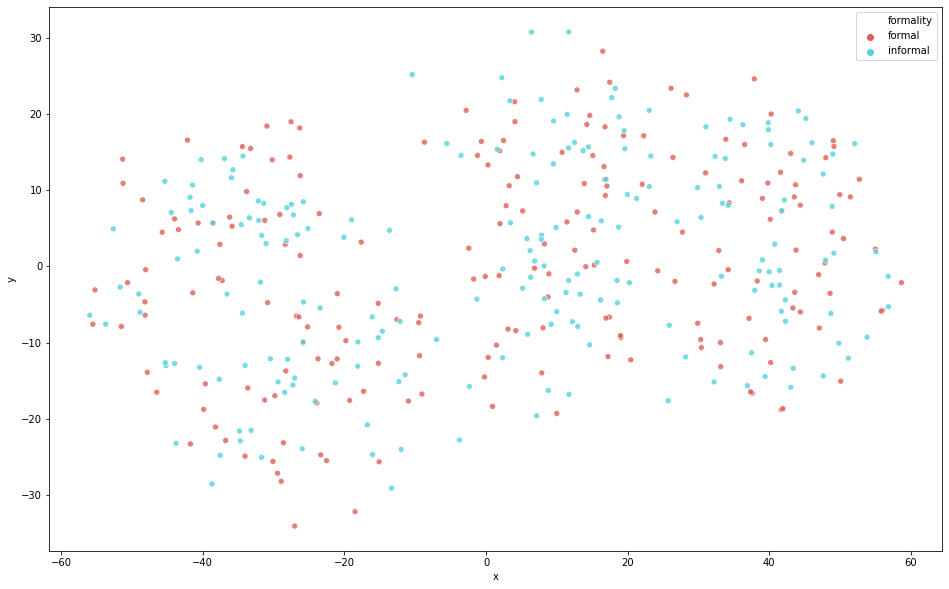

In [41]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="x", y="y",
    hue="formality",
    palette=sns.color_palette("hls", 2),
    data=sub_tsne_df,
    legend="full",
    alpha=0.8
)

## Formality direction

In [0]:
FR_formal_tsne = tsne_df.loc[tsne_df.group == 0]
FR_informal_tsne = tsne_df.loc[tsne_df.group == 1].reset_index(inplace=False)

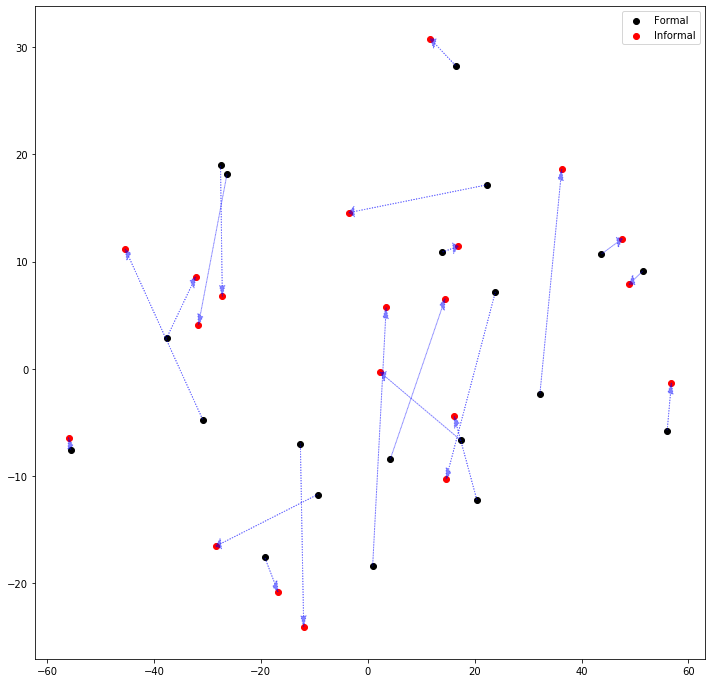

In [44]:
NUM_VECTORS = 20
x_formal = FR_formal_tsne['x'].values[:NUM_VECTORS]
y_formal = FR_formal_tsne['y'].values[:NUM_VECTORS]

x_informal = FR_informal_tsne['x'].values[:NUM_VECTORS]
y_informal = FR_informal_tsne['y'].values[:NUM_VECTORS]

x_direction = x_informal - x_formal
y_direction = y_informal - y_formal

plt.figure(figsize=(12,12))
plt.scatter(x_formal, y_formal, c="black")
plt.scatter(x_informal, y_informal, c="red")

for i in range(NUM_VECTORS):
  plt.arrow(x_formal[i], y_formal[i], x_direction[i], y_direction[i], head_width=1, head_length=1, length_includes_head=True, ls=':', color='blue', alpha=0.5)

plt.legend(['Formal', 'Informal'])
plt.show()

# Changing formality in latent space

### Continously sampling between sentences

#### Sampling between different sentences

In [45]:
sentence1 = sp.decode_ids(data_dict["train"]["formal"][42].tolist())
sentence2 = sp.decode_ids(data_dict["train"]["informal"][42].tolist())
print(f"Sentence 1: {sentence1}")
print(f"Sentence 2: {sentence2}")

Sentence 1: are you hesitant to talk to them.
Sentence 2: do u hesitate to talk to them?


In [46]:
z_1 = get_latent_rep_of_sentence(rnn_vae, sp, sentence1)
z_2 = get_latent_rep_of_sentence(rnn_vae, sp, sentence2)

for i in range(1,11):
  k = i/10
  traversing_z = z_2 * k + (1 - k) * z_1
  recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, traversing_z, 12)
  print(f"{1-k:.2f} * sentence 1 + {k:.2f} * sentence 2 = {recon}")


0.90 * sentence 1 + 0.10 * sentence 2 = are you comfortable in your own skin??
0.80 * sentence 1 + 0.20 * sentence 2 = are you comfortable in your own skin??
0.70 * sentence 1 + 0.30 * sentence 2 = are you comfortable in your own skin??
0.60 * sentence 1 + 0.40 * sentence 2 = are you comfortable in your own skin??
0.50 * sentence 1 + 0.50 * sentence 2 = do you think i should ask him?
0.40 * sentence 1 + 0.60 * sentence 2 = do you think i should ask him?
0.30 * sentence 1 + 0.70 * sentence 2 = do you think i should ask him?
0.20 * sentence 1 + 0.80 * sentence 2 = do you think i should ask him?
0.10 * sentence 1 + 0.90 * sentence 2 = do you think i should ask him?
0.00 * sentence 1 + 1.00 * sentence 2 = do you think i should ask him?


#### Sampling between formalities

In [80]:
# 103
# 5323
sentence_num = 10000
sentence1 = sp.decode_ids(data_dict["train"]["formal"][sentence_num].tolist())
sentence2 = sp.decode_ids(data_dict["train"]["informal"][sentence_num].tolist())
print(f"Sentence 1: {sentence1}")
print(f"Sentence 2: {sentence2}")

Sentence 1: you must start at some point.
Sentence 2: but you got to start some where.


In [81]:
z_1 = get_latent_rep_of_sentence(rnn_vae, sp, sentence1)
z_2 = get_latent_rep_of_sentence(rnn_vae, sp, sentence2)

for i in range(0,11):
  k = i/10
  traversing_z = z_2 * k + (1 - k) * z_1
  recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, traversing_z, 12)
  print(f"{1-k:.2f} * sentence 1 + {k:.2f} * sentence 2 = {recon}")


1.00 * sentence 1 + 0.00 * sentence 2 = you should ask her about it.
0.90 * sentence 1 + 0.10 * sentence 2 = you should ask her about it.
0.80 * sentence 1 + 0.20 * sentence 2 = you should ask her about it.
0.70 * sentence 1 + 0.30 * sentence 2 = you should ask her about it.
0.60 * sentence 1 + 0.40 * sentence 2 = i have never kissed a boy!
0.50 * sentence 1 + 0.50 * sentence 2 = i have never kissed a boy before.
0.40 * sentence 1 + 0.60 * sentence 2 = i have never cheated on my boyfriend.
0.30 * sentence 1 + 0.70 * sentence 2 = but i dont know what to do.
0.20 * sentence 1 + 0.80 * sentence 2 = but i dont know what to do.
0.10 * sentence 1 + 0.90 * sentence 2 = but i dont know what to do.
0.00 * sentence 1 + 1.00 * sentence 2 = but i dont know what to do.


### Adding mean formality

In [0]:
formal_embeds = np.array(FR_formal_embeds + EM_formal_embeds)
informal_embeds = np.array(FR_informal_embeds + EM_informal_embeds)
dirs = informal_embeds - formal_embeds
mean_dir = np.mean(dirs, axis=0).tolist()

In [0]:
test_sentence = sp.decode_ids(data_dict["EM"]["train"]["formal"][700].tolist())
target_sentence = sp.decode_ids(data_dict["EM"]["train"]["informal"][700].tolist())
print(f"test sentence: {test_sentence}")
print(f"target sentence: {target_sentence}")

test sentence: the majority of the websites are starting with tamil.
target sentence: most of the websites starting with tamil


In [0]:
start_z = get_latent_rep_of_sentence(rnn_vae, sp, test_sentence)
moved_z = start_z + torch.tensor(mean_dir).cuda()
unmoved_recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, start_z, 12)
recon = deterministic_generate_sentence_from_latent(rnn_vae, sp, moved_z, 12)
print(f"unmoved recon: {unmoved_recon}")
print(f"moved recon: {recon}")

unmoved recon: the majority of my friends are men as well.
moved recon: the majority of my friends are men as well.
